# DS Practicum 1

## Question 1

**Problem:**

## Question 2

**Loading Data**

In [3]:
import pandas as pd

# Load the CSV with the correct filename
df = pd.read_csv("2019_ONTIME_REPORTING_FSW-1.csv")

# View the first 5 rows
df.head()

,FL_DATE,CARRIER_CODE,TAIL_NUM,FL_NUM,ORIGIN,ORIGIN_ST,DEST,DEST_ST,DEP_TIME,DEP_DELAY,ARR_TIME,ARR_DELAY,ELAPSED_TIME,DISTANCE
0,2019-10-01,AA,N916NN,2311,TUS,AZ,ORD,IL,828.0,0.0,1353.0,0.0,205.0,1437
1,2019-10-01,AA,N733UW,2315,PHX,AZ,DEN,CO,1907.0,0.0,2159.0,0.0,112.0,602
2,2019-10-01,AA,N140AN,2318,DFW,TX,LAX,CA,1904.0,104.0,2016.0,101.0,192.0,1235
3,2019-10-01,AA,N925AN,2325,SNA,CA,DFW,TX,1729.0,4.0,2215.0,3.0,166.0,1205
4,2019-10-01,AA,N143AN,2328,ATL,GA,LAX,CA,656.0,0.0,841.0,0.0,285.0,1947


**Inspecting Data and Converting to Suitable Types**

In [4]:
# inspect the dimensions
print(f"There are {df.shape[0]} rows and {df.shape[1]} columns.")

# inspect data types
df.info()

There are 1897503 rows and 14 columns.
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1897503 entries, 0 to 1897502
Data columns (total 14 columns):
 #   Column        Dtype  
---  ------        -----  
 0   FL_DATE       object 
 1   CARRIER_CODE  object 
 2   TAIL_NUM      object 
 3   FL_NUM        int64  
 4   ORIGIN        object 
 5   ORIGIN_ST     object 
 6   DEST          object 
 7   DEST_ST       object 
 8   DEP_TIME      float64
 9   DEP_DELAY     float64
 10  ARR_TIME      float64
 11  ARR_DELAY     float64
 12  ELAPSED_TIME  float64
 13  DISTANCE      int64  
dtypes: float64(5), int64(2), object(7)
memory usage: 202.7+ MB


**Dimensions** <br></br>There are 1897503 rows and 14 columns of data.  

**Changes in Data Types**
<br></br>
CARRIER_CODE, TAIL_NUM, FL_NUM, ORIGIN, ORIGIN_ST, DEST, and DEST_ST will be changed to category variables because they represent labels.  FL_DATE will be changed to datetime because it represents a date.  DEP_TIME, DEP_DELAY, ARR_TIME, ARR_DELAY, and ELAPSED_TIME will be changed to integers as well.

In [5]:
# change FL_DATE to datetime
df["FL_DATE"] = pd.to_datetime(df["FL_DATE"])

# change CARRIER_CODE, TAIL_NUM, FL_NUM, ORIGIN, ORIGIN_ST, DEST, DEST_ST to
# categorical variables
df["FL_NUM"] = df["FL_NUM"].astype("category")
df["CARRIER_CODE"] = df["CARRIER_CODE"].astype("category")
df["TAIL_NUM"] = df["TAIL_NUM"].astype("category")
df["ORIGIN"] = df["ORIGIN"].astype("category")
df["ORIGIN_ST"] = df["ORIGIN_ST"].astype("category")
df["DEST"] = df["DEST"].astype("category")
df["DEST_ST"] = df["DEST_ST"].astype("category")

# change DEP_TIME, DEP_DELAY, ARR_TIME, ARR_DELAY, ELAPSED_TIME to Int64
df["DEP_TIME"] = df["DEP_TIME"].astype("Int64")
df["DEP_DELAY"] = df["DEP_DELAY"].astype("Int64")
df["ARR_TIME"] = df["ARR_TIME"].astype("Int64")
df["ARR_DELAY"] = df["ARR_DELAY"].astype("Int64")
df["ELAPSED_TIME"] = df["ELAPSED_TIME"].astype("Int64")

# verify changes 
df.dtypes

FL_DATE         datetime64[ns]
CARRIER_CODE          category
TAIL_NUM              category
FL_NUM                category
ORIGIN                category
ORIGIN_ST             category
DEST                  category
DEST_ST               category
DEP_TIME                 Int64
DEP_DELAY                Int64
ARR_TIME                 Int64
ARR_DELAY                Int64
ELAPSED_TIME             Int64
DISTANCE                 int64
dtype: object

In [6]:
# verify changes by checking first 5 rows
df.head()

,FL_DATE,CARRIER_CODE,TAIL_NUM,FL_NUM,ORIGIN,ORIGIN_ST,DEST,DEST_ST,DEP_TIME,DEP_DELAY,ARR_TIME,ARR_DELAY,ELAPSED_TIME,DISTANCE
0,2019-10-01,AA,N916NN,2311,TUS,AZ,ORD,IL,828,0,1353,0,205,1437
1,2019-10-01,AA,N733UW,2315,PHX,AZ,DEN,CO,1907,0,2159,0,112,602
2,2019-10-01,AA,N140AN,2318,DFW,TX,LAX,CA,1904,104,2016,101,192,1235
3,2019-10-01,AA,N925AN,2325,SNA,CA,DFW,TX,1729,4,2215,3,166,1205
4,2019-10-01,AA,N143AN,2328,ATL,GA,LAX,CA,656,0,841,0,285,1947


In [7]:
# percentage of missing values
df.isnull().mean()*100

FL_DATE         0.000000
CARRIER_CODE    0.000000
TAIL_NUM        0.252490
FL_NUM          0.000000
ORIGIN          0.000000
ORIGIN_ST       0.000000
DEST            0.000000
DEST_ST         0.000000
DEP_TIME        1.407481
DEP_DELAY       1.407903
ARR_TIME        1.488482
ARR_DELAY       1.680314
ELAPSED_TIME    1.680314
DISTANCE        0.000000
dtype: float64

In [8]:
# distribution of missing values in rows
df.isnull().sum(axis=1).sort_values(ascending=False).value_counts()

0    1865619
5      21918
6       4790
2       3640
3       1529
4          7
Name: count, dtype: int64

**Missing Values**<br></br>Based on this information, missing data is not widespread since only a small percentage of rows have missing data.  Out of the rows with missing data, most have 5 or 6 missing columns.  Since the columns with missing values are related to arrival, departure, and delay times and this is important to the data science question on air traffic in part 1, these rows should be dropped.

In [9]:
# remove rows with null values
df = df.dropna()

# verify changes (only rows with 0 null values retained)
df.isnull().sum(axis=1).sort_values(ascending=False).value_counts()

0    1865619
Name: count, dtype: int64

**Invalid Data**

Invalid times of 2400 for DEP_TIME were corrected by changing them to 0 and updating the FL_DATE by 1 day.  Rows with times of 2400 were not excluded since the data is not necessarily incorrect, just inconsistent since 2400 means 24 hours later or the next day.  This means the flight actually departed at midnight the next day.

In [29]:
# determine number of rows with invalid DEP_TIME
invalid_dep_time_df = df[df["DEP_TIME"] == 2400]
print(f"{invalid_dep_time_df.shape[0]} rows with invalid DEP_TIME values")
# display rows with invalid departure times to verify later
invalid_dep_time_df.head()

241 rows with invalid DEP_TIME values


,FL_DATE,CARRIER_CODE,TAIL_NUM,FL_NUM,ORIGIN,ORIGIN_ST,DEST,DEST_ST,DEP_TIME,DEP_DELAY,ARR_TIME,ARR_DELAY,ELAPSED_TIME,DISTANCE
34864,2019-10-07,DL,N383DZ,487,LAS,NV,ATL,GA,2400,1,635,0,215,1747
40416,2019-10-08,AA,N825NN,1542,PHX,AZ,DCA,VA,2400,0,707,0,247,1979
50938,2019-10-10,DL,N841MH,1362,LAX,CA,JFK,NY,2400,5,817,0,317,2475
65478,2019-10-13,NK,N627NK,456,LAS,NV,ORD,IL,2400,0,517,0,197,1514
68336,2019-10-14,DL,N844MH,1362,LAX,CA,JFK,NY,2400,5,803,0,303,2475


There are 241 rows with invalid departure times.

In [37]:
# update rows with invalid DEP_TIME
dep_time_filter = df["DEP_TIME"] == 2400
df.loc[dep_time_filter, "DEP_TIME"] = 0
df.loc[dep_time_filter, "FL_DATE"] = df.loc[dep_time_filter, "FL_DATE"] + pd.DateOffset(days=1)

# verify changes by checking that there are no rows with 2400 as DEP_TIME
new_dep_time_df = df[df["DEP_TIME"] == 2400]
print(f"{new_dep_time_df.shape[0]} rows with invalid DEP_TIME values")

0 rows with invalid DEP_TIME values


There are now 0 rows with invalid departure times.

The other columns were checked for potential invalid data but no such values were found.  Checked for invalid CARRIER_CODE (not exactly two characters), FL_NUM(not exactly 1 to 4 digits), TAIL_NUM (incorrect format or doesn't start with 'N'), ORIGIN/DEST (not exactly 3 uppercase letters), ORIGIN_ST/DEST_ST (not exactly 2 uppercase letters), and DISTANCE (negative distances).  

In [ ]:
# additional checks here!

## Question 3

1. Explore patterns in the region i.e. the 3 states (AZ, NV, CA). Determine which region has the most air traffic. Comment on your findings and visualize the results. Note: it's important to explain your rational for determining what is "the most air traffic". For example, are you evaluating the frequency of flights or total flight time. Justify your response.

In [47]:
# filter data for AZ, NV, and CA
states = ['AZ', 'NV', 'CA']
state_filter = df['ORIGIN_ST'].isin(states) | df['DEST_ST'].isin(states)
filtered_df = df[state_filter]
# verify results by checking how many rows don't have an original location or destination of one of the specified states
invalidRows = filtered_df[~df['ORIGIN_ST'].isin(states) & ~df['DEST_ST'].isin(states)].shape[0]
print(f"There are {invalidRows} rows without an original location or destination of AZ, NV, or CA")

There are 0 rows without an original location or destination of AZ, NV, or CA


In [50]:
# determine time span of data
filtered_df['FL_DATE'].value_counts(ascending=True)

FL_DATE
2020-01-01       1
2019-11-28    3547
2019-01-19    3822
2019-02-02    3829
2019-02-09    3980
              ... 
2019-08-08    5628
2019-08-16    5647
2019-08-12    5661
2019-08-05    5675
2019-08-09    5693
Name: count, Length: 366, dtype: int64

**Criteria For Most Air Traffic**
<br></br>
The region with the most air traffice will be determined by analyzing the frequency of flights that have arrived at that region and the frequency of flights that have departed from that region between August 9, 2019 and January 1, 2020.  The number of incoming and outgoing flights per day from each region will be analyzed in particular.

In [97]:
# airport data from AZ
az_filter = df['ORIGIN_ST'].isin(['AZ']) | df['DEST_ST'].isin(['AZ'])
az_airport_df = filtered_df[az_filter]
az_airport_df.head()

,FL_DATE,CARRIER_CODE,TAIL_NUM,FL_NUM,ORIGIN,ORIGIN_ST,DEST,DEST_ST,DEP_TIME,DEP_DELAY,ARR_TIME,ARR_DELAY,ELAPSED_TIME,DISTANCE
0,2019-10-01,AA,N916NN,2311,TUS,AZ,ORD,IL,828,0,1353,0,205,1437
1,2019-10-01,AA,N733UW,2315,PHX,AZ,DEN,CO,1907,0,2159,0,112,602
5,2019-10-01,AA,N816NN,2339,PHX,AZ,JFK,NY,911,0,1702,0,291,2153
10,2019-10-01,AA,N982AN,2369,JFK,NY,PHX,AZ,1053,0,1250,0,297,2153
11,2019-10-01,AA,N177US,2371,EWR,NJ,PHX,AZ,941,0,1155,0,314,2133


In [82]:
# number of flights that arrived at AZ in past year
az_airport_df_arrival = az_airport_df[az_airport_df["DEST_ST"] == 'AZ']
print(f"{az_airport_df_arrival.shape[0]} flights arrived at AZ in past year")

201744 flights arrived at AZ in past year


In [95]:
# count number of flights per day that arrive at AZ
az_arrival_flights_per_day = az_airport_df_arrival.groupby("FL_DATE").size()

**AZ Arrival Flights Per Day Statistics**

In [110]:
# calculate statistics for flight frequencies
az_mean_arrival_flights = az_arrival_flights_per_day.mean()
az_median_arrival_flights = az_arrival_flights_per_day.median()
az_mode_arrival_flights = az_arrival_flights_per_day.mode().iloc[0]
az_std_arrival_flights = az_arrival_flights_per_day.std()
print("AZ Arrival Flights Per Day Statistics:")
print(f"mean: {az_mean_arrival_flights}")
print(f"median: {az_median_arrival_flights}")
print(f"mode: {az_mode_arrival_flights}")
print(f"std: {az_std_arrival_flights}")

AZ Arrival Flights Per Day Statistics:
mean: 552.7232876712329
median: 556.0
mode: 576
std: 42.88923415898145


In [84]:
# number of flights that departed from AZ in past year
az_airport_df_departure = az_airport_df[az_airport_df["ORIGIN_ST"] == 'AZ']
print(f"{az_airport_df_departure.shape[0]} flights departed from AZ in past year")

201804 flights departed from AZ in past year


In [98]:
# count number of flights per day that depart from AZ
az_departure_flights_per_day = az_airport_df_departure.groupby("FL_DATE").size()

**AZ Departure Flights Per Day Statistics**

In [111]:
# calculate statistics for flight frequencies
az_mean_departure_flights = az_departure_flights_per_day.mean()
az_median_departure_flights = az_departure_flights_per_day.median()
az_mode_departure_flights = az_departure_flights_per_day.mode().iloc[0]
az_std_departure_flights = az_departure_flights_per_day.std()
print("AZ Departure Flights Per Day Statistics:")
print(f"mean: {az_mean_departure_flights}")
print(f"median: {az_median_departure_flights}")
print(f"mode: {az_mode_departure_flights}")
print(f"std: {az_std_departure_flights}")

AZ Departure Flights Per Day Statistics:
mean: 552.8876712328768
median: 556.0
mode: 571
std: 42.849096138560675


In [56]:
# airport data from NV
nv_filter = df['ORIGIN_ST'].isin(['NV']) | df['DEST_ST'].isin(['NV'])
nv_airport_df = filtered_df[nv_filter]
nv_airport_df.head()

,FL_DATE,CARRIER_CODE,TAIL_NUM,FL_NUM,ORIGIN,ORIGIN_ST,DEST,DEST_ST,DEP_TIME,DEP_DELAY,ARR_TIME,ARR_DELAY,ELAPSED_TIME,DISTANCE
14,2019-10-01,AA,N352PS,2390,DFW,TX,LAS,NV,2225,0,2310,0,165,1055
16,2019-10-01,AA,N953NN,2407,LAS,NV,ORD,IL,1143,0,1716,0,213,1514
22,2019-10-01,AA,N922AN,2427,ORD,IL,RNO,NV,1216,0,1432,0,256,1671
23,2019-10-01,AA,N922AN,2427,RNO,NV,ORD,IL,1523,0,2143,18,260,1671
28,2019-10-01,AA,N305NX,2448,DFW,TX,RNO,NV,1722,0,1839,0,197,1345


In [89]:
# number of flights that arrived at NV in past year
nv_airport_df_arrival = nv_airport_df[nv_airport_df["DEST_ST"] == 'NV']
print(f"{nv_airport_df_arrival.shape[0]} flights arrived at NV in past year")

182115 flights arrived at NV in past year


In [99]:
# count number of flights per day that arrive at NV
nv_arrival_flights_per_day = nv_airport_df_arrival.groupby("FL_DATE").size()

**NV Arrival Flights Per Day Statistics:**

In [112]:
# calculate statistics for flight frequencies
nv_mean_arrival_flights = nv_arrival_flights_per_day.mean()
nv_median_arrival_flights = nv_arrival_flights_per_day.median()
nv_mode_arrival_flights = nv_arrival_flights_per_day.mode().iloc[0]
nv_std_arrival_flights = nv_arrival_flights_per_day.std()
print("NV Arrival Flights Per Day Statistics:")
print(f"mean: {nv_mean_arrival_flights}")
print(f"median: {nv_median_arrival_flights}")
print(f"mode: {nv_mode_arrival_flights}")
print(f"std: {nv_std_arrival_flights}")

NV Arrival Flights Per Day Statistics:
mean: 498.94520547945206
median: 505.0
mode: 501
std: 43.27851610608923


In [93]:
# number of flights that departed from NV in past year
nv_airport_df_departure = nv_airport_df[nv_airport_df["ORIGIN_ST"] == 'NV']
print(f"{nv_airport_df_departure.shape[0]} flights departed from NV in past year")

181985 flights departed from NV in past year


In [ ]:
# count number of flights per day that depart from NV
nv_departure_flights_per_day = nv_airport_df_departure.groupby("FL_DATE").size()

**NV Departure Flights Per Day Statistics**

In [113]:
# calculate statistics for flight frequencies
nv_mean_departure_flights = nv_departure_flights_per_day.mean()
nv_median_departure_flights = nv_departure_flights_per_day.median()
nv_mode_departure_flights = nv_departure_flights_per_day.mode().iloc[0]
nv_std_departure_flights = nv_departure_flights_per_day.std()
print("NV Departure Flights Per Day Statistics:")
print(f"mean: {nv_mean_departure_flights}")
print(f"median: {nv_median_departure_flights}")
print(f"mode: {nv_mode_departure_flights}")
print(f"std: {nv_std_departure_flights}")

NV Departure Flights Per Day Statistics:
mean: 498.5890410958904
median: 505.0
mode: 536
std: 42.593670406450784


In [57]:
# airport data from CA
ca_filter = df['ORIGIN_ST'].isin(['CA']) | df['DEST_ST'].isin(['CA'])
ca_airport_df = filtered_df[ca_filter]
ca_airport_df.head()

,FL_DATE,CARRIER_CODE,TAIL_NUM,FL_NUM,ORIGIN,ORIGIN_ST,DEST,DEST_ST,DEP_TIME,DEP_DELAY,ARR_TIME,ARR_DELAY,ELAPSED_TIME,DISTANCE
2,2019-10-01,AA,N140AN,2318,DFW,TX,LAX,CA,1904,104,2016,101,192,1235
3,2019-10-01,AA,N925AN,2325,SNA,CA,DFW,TX,1729,4,2215,3,166,1205
4,2019-10-01,AA,N143AN,2328,ATL,GA,LAX,CA,656,0,841,0,285,1947
6,2019-10-01,AA,N150NN,2349,LAX,CA,BOS,MA,2149,0,559,0,310,2611
7,2019-10-01,AA,N994AN,2354,LAX,CA,DFW,TX,1128,0,1620,0,172,1235


In [104]:
# number of flights that arrived at CA in past year
ca_airport_df_arrival = ca_airport_df[ca_airport_df["DEST_ST"] == 'CA']
print(f"{ca_airport_df_arrival.shape[0]} flights arrived at CA in past year")

799137 flights arrived at CA in past year


In [105]:
# count number of flights per day that arrive at AZ
ca_arrival_flights_per_day = ca_airport_df_arrival.groupby("FL_DATE").size()

**CA Arrival Flights Per Day Statistics:**

In [114]:
# calculate statistics for flight frequencies
ca_mean_arrival_flights = ca_arrival_flights_per_day.mean()
ca_median_arrival_flights = ca_arrival_flights_per_day.median()
ca_mode_arrival_flights = ca_arrival_flights_per_day.mode().iloc[0]
ca_std_arrival_flights = ca_arrival_flights_per_day.std()
print("CA Arrival Flights Per Day Statistics:")
print(f"mean: {ca_mean_arrival_flights}")
print(f"median: {ca_median_arrival_flights}")
print(f"mode: {ca_mode_arrival_flights}")
print(f"std: {ca_std_arrival_flights}")

CA Arrival Flights Per Day Statistics:
mean: 2183.434426229508
median: 2218.5
mode: 2184
std: 223.8513690249122


In [107]:
# number of flights that departed from AZ in past year
ca_airport_df_departure = ca_airport_df[ca_airport_df["ORIGIN_ST"] == 'CA']
print(f"{ca_airport_df_departure.shape[0]} flights departed from CA in past year")

798690 flights departed from CA in past year


In [108]:
# count number of flights per day that depart from CA
ca_departure_flights_per_day = ca_airport_df_departure.groupby("FL_DATE").size()

**CA Departure Flights Per Day Statistics**

In [115]:
# calculate statistics for flight frequencies
ca_mean_departure_flights = ca_departure_flights_per_day.mean()
ca_median_departure_flights = ca_departure_flights_per_day.median()
ca_mode_departure_flights = ca_departure_flights_per_day.mode().iloc[0]
ca_std_departure_flights = ca_departure_flights_per_day.std()
print("CA Departure Flights Per Day Statistics:")
print(f"mean: {ca_mean_departure_flights}")
print(f"median: {ca_median_departure_flights}")
print(f"mode: {ca_mode_departure_flights}")
print(f"std: {ca_std_departure_flights}")

CA Departure Flights Per Day Statistics:
mean: 2188.1917808219177
median: 2226.0
mode: 2291
std: 193.2162468948397


**Visualize AZ, NV, and CA Flights Per Day**

In [121]:
flights_per_day_arrival = {
    'State': ['AZ', 'NV', 'CA'],
    'Mean': [az_mean_arrival_flights, nv_mean_arrival_flights, ca_mean_arrival_flights],
    'Median': [az_median_arrival_flights, nv_median_arrival_flights, ca_median_arrival_flights],
    'Mode': [az_mode_arrival_flights, nv_mode_arrival_flights, ca_mode_arrival_flights],
    'Std Dev': [az_std_arrival_flights, nv_std_arrival_flights, ca_std_arrival_flights]
}

flights_per_day_departure = {
    'State': ['AZ', 'NV', 'CA'],
    'Mean': [az_mean_departure_flights, nv_mean_departure_flights, ca_mean_departure_flights],
    'Median': [az_median_departure_flights, nv_median_departure_flights, ca_median_departure_flights],
    'Mode': [az_mode_departure_flights, nv_mode_departure_flights, ca_mode_departure_flights],
    'Std Dev': [az_std_departure_flights, nv_std_departure_flights, ca_std_departure_flights]
}

flights_per_day_arrival_df = pd.DataFrame(flights_per_day_arrival)
flights_per_day_departure_df = pd.DataFrame(flights_per_day_departure)

**Flights Per Day Arrival**

<Axes: title={'center': 'Daily Flights Per Region'}, xlabel='Region', ylabel='Flights'>

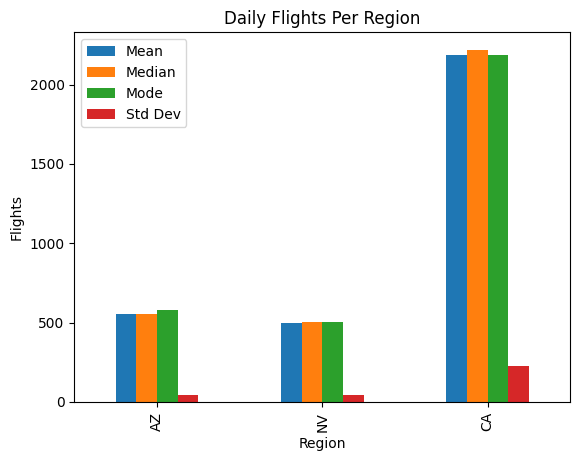

In [125]:
flights_per_day_arrival_df.index = ['AZ', 'NV', 'CA']
flights_per_day_arrival_df.plot(kind="bar", title="Daily Arrival Flights Per Region", xlabel="Region", ylabel="Flights")

**Flights Per Day Departure**

<Axes: title={'center': 'Daily Departure Flights Per Region'}, xlabel='Region', ylabel='Flights'>

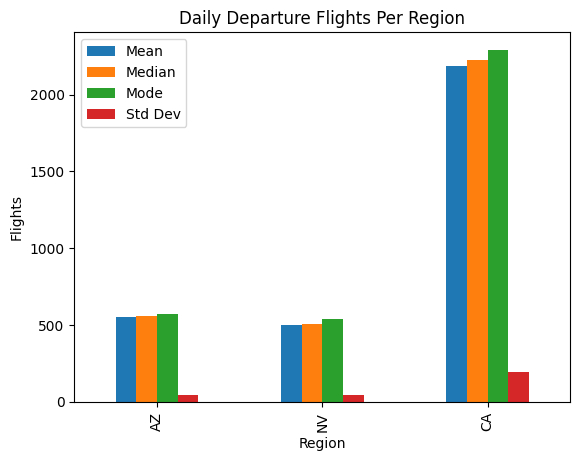

In [126]:
flights_per_day_departure_df.index = ['AZ', 'NV', 'CA']
flights_per_day_departure_df.plot(kind="bar", title="Daily Departure Flights Per Region", xlabel="Region", ylabel="Flights")

**Analysis**

Based on the provided data, CA has the most air traffic as it has the greatest average arrival and departure flights per day.  CA has an average of 2183 arrival and and 2188 departure flights daily.  AZ has an average of 552 arrival and 552 departure flights daily, while NV has an average of 498 arrival and 498 departure flights daily.

Based on the graph results, CA clearly dominates in terms of number of flights and has a greater standard deviation, indicating more daily variability than the other two regions.  AZ and NV have similar means and medians with low standard deviations, implying more consistent day to day air traffic.  Since the mean, median, and mode are similar for all regions in terms of arrival and departure flights per day, this means that there are no extreme daily flight flight values affecting the average.

In terms of total number of flights, AZ, NV, and CA had 201744, 182115, and 798690 arrival flights in the past year respectively.  AZ, NV, and CA had 201804, 181985, and 799137 departure flights in the past year respectively.  This further proves that CA has the greatest air traffic, followed by AZ and then NV based on measures of daily fights.  


## Question 4

## Question 5

## Question 6

## Question 7